In [1]:
setwd("..")

In [48]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 200)

In [4]:
library(readr)
library(dplyr)
library(purrr)
library(tibble)
library(ggplot2)
library(ggpubr)
library(ggthemes)

## functions

In [5]:
read_gather <- function(path){
  gather <- read_csv(path, col_types = "ddddddddcccddddcccd")
}

## read in data

In [6]:
gtdb_lineages <- read_csv("https://osf.io/p6z3w/download", show_col_types = F)

In [7]:
files <- c(Sys.glob("outputs/rnaseq_sourmash_gather/*csv"), Sys.glob("outputs/rnaseq_sourmash_gather_spu/*csv"))
gather_results <- files %>%
  map_dfr(read_gather) %>%
  mutate(source = ifelse(grepl(pattern = "X", x = query_name), "public", "hogan lab"),
         exp    = ifelse(grepl(pattern = "_M", x = query_name), "metals",
                         ifelse(grepl(pattern = "X", x = query_name), "public", "non-metals"))) %>% # label sources
  mutate(accession = gsub(" .*", "", name)) %>%
  left_join(gtdb_lineages, by = c("accession" = "ident")) %>%
  mutate(species = ifelse(is.na(species), "human", species))

In [8]:
head(gather_results)

intersect_bp,f_orig_query,f_match,f_unique_to_query,f_unique_weighted,average_abund,median_abund,std_abund,name,filename,⋯,source,exp,accession,superkingdom,phylum,class,order,family,genus,species
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1964000,0.5682870,0.29418814,0.56828704,0.869461014,16.624236,2,212.753154,"GCF_001451165.1 Pseudomonas aeruginosa strain=WH-SGI-V-07411, WH-SGI-V-07411",/Users/tr/github/2022-cf-sputum/inputs/sourmash_dbs/gtdb-rs202.genomic.k31.zip,⋯,public,public,GCF_001451165.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__Pseudomonas,s__Pseudomonas aeruginosa
884000,0.5450062,0.13688448,0.54500617,0.774431974,6.400452,3,25.807858,"GCF_900406945.1 Pseudomonas aeruginosa strain=KCRI-379A, De novo assembly of KCRI isolate RDK06_379A",/Users/tr/github/2022-cf-sputum/inputs/sourmash_dbs/gtdb-rs202.genomic.k31.zip,⋯,public,public,GCF_900406945.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__Pseudomonas,s__Pseudomonas aeruginosa
2246000,0.6308989,0.31912475,0.63089888,0.889500936,7.189671,2,25.641938,"GCF_002330125.1 Pseudomonas aeruginosa strain=env396b, ASM233012v1",/Users/tr/github/2022-cf-sputum/inputs/sourmash_dbs/gtdb-rs202.genomic.k31.zip,⋯,public,public,GCF_002330125.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__Pseudomonas,s__Pseudomonas aeruginosa
2016000,0.5662921,0.01198322,0.02247191,0.006169439,1.400000,1,1.044031,"GCF_001451165.1 Pseudomonas aeruginosa strain=WH-SGI-V-07411, WH-SGI-V-07411",/Users/tr/github/2022-cf-sputum/inputs/sourmash_dbs/gtdb-rs202.genomic.k31.zip,⋯,public,public,GCF_001451165.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__Pseudomonas,s__Pseudomonas aeruginosa
4804000,0.2866348,0.69967958,0.28663484,0.845091841,29.382598,5,360.105069,"GCF_013912985.1 Pseudomonas aeruginosa strain=PAL1.32, ASM1391298v1",/Users/tr/github/2022-cf-sputum/inputs/sourmash_dbs/gtdb-rs202.genomic.k31.zip,⋯,public,public,GCF_013912985.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__Pseudomonas,s__Pseudomonas aeruginosa
4658000,0.2779236,0.07752915,0.02935561,0.021409584,7.268293,3,13.616748,"GCF_900147575.1 Pseudomonas aeruginosa, 431",/Users/tr/github/2022-cf-sputum/inputs/sourmash_dbs/gtdb-rs202.genomic.k31.zip,⋯,public,public,GCF_900147575.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae,g__Pseudomonas,s__Pseudomonas aeruginosa


## Strain plots

In [9]:
# medically relevant species to CF
species_of_interest <- c(
    "s__Pseudomonas aeruginosa",
    "s__Staphylococcus aureus",
    "s__Burkholderia multivorans",
    "s__Burkholderia cepacia",
    "s__Mycobacterium avium",
    "s__Mycobacterium abscessus",
    "s__Haemophilus influenzae",
    "s__Stenotrophomonas maltophilia",
    "s__Burkholderia cenocepacia_B",    
    "s__Achromobacter xylosoxidans",
    "human")

In [10]:
gather_results_strain <- gather_results %>%
  mutate(strain_label = ifelse(species %in% c("s__Pseudomonas aeruginosa", "human"), name, "other"))

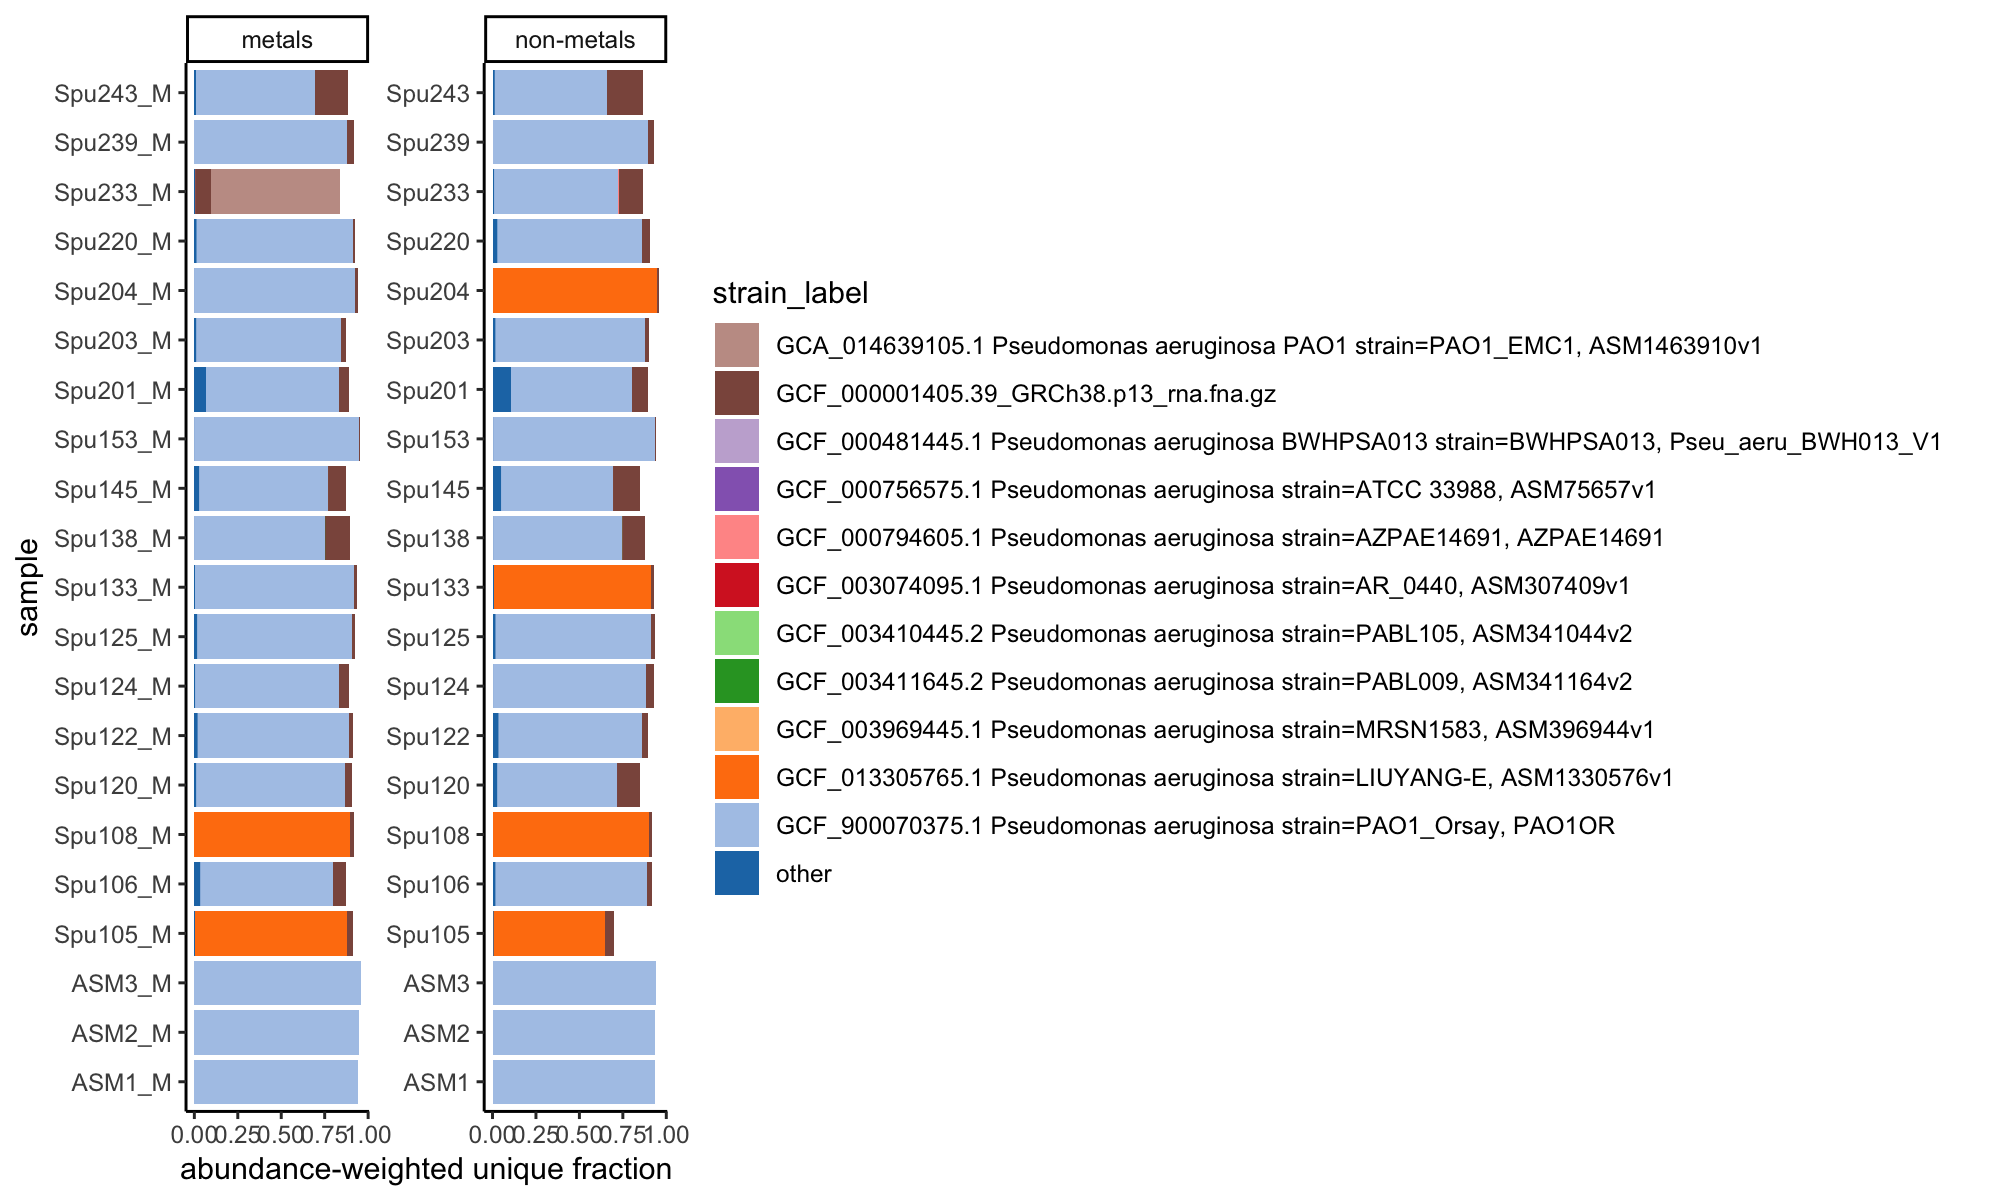

In [74]:
ggplot(gather_results_strain %>% filter(source == "hogan lab")%>% filter(!query_name %in% c("M633", "M632", "M631")), 
       aes(x = query_name, y = f_unique_weighted, fill = strain_label)) + 
  geom_col() +
  scale_fill_tableau(palette = "Classic 20", direction = -1) +
  theme_classic() +
  coord_flip() + facet_wrap(~exp, scales = "free_y") +
  labs(x = "sample", y = "abundance-weighted unique fraction")

Warning message in check_pal_n(n, max_n):
“This palette can handle a maximum of 20 values.You have supplied 35.”


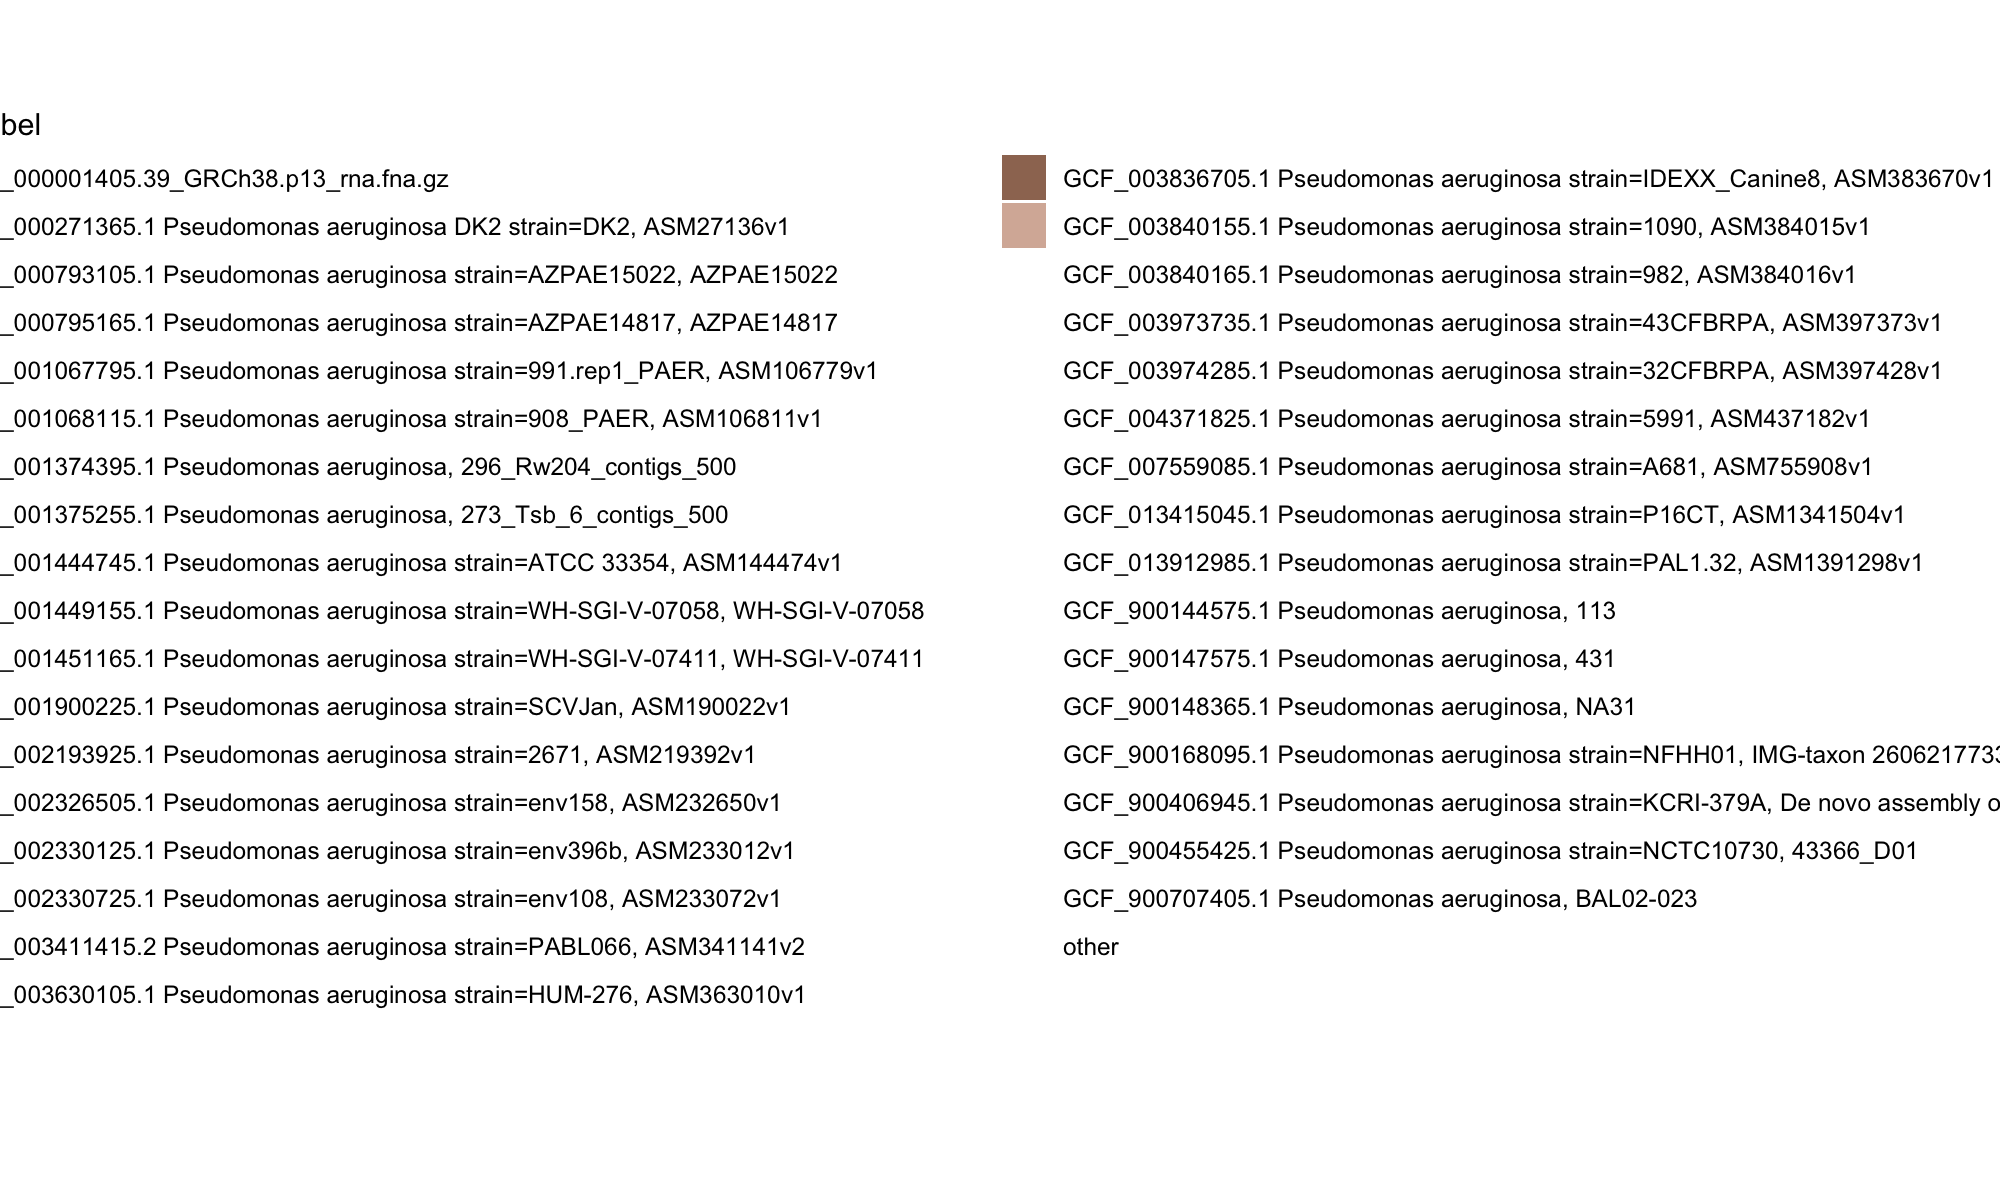

In [75]:
ggplot(gather_results_strain %>% filter(source == "public"), 
       aes(x = query_name, y = f_unique_weighted, fill = strain_label)) + 
  geom_col() +
  scale_fill_tableau(palette = "Tableau 20") +
  theme_classic() +
  coord_flip() 

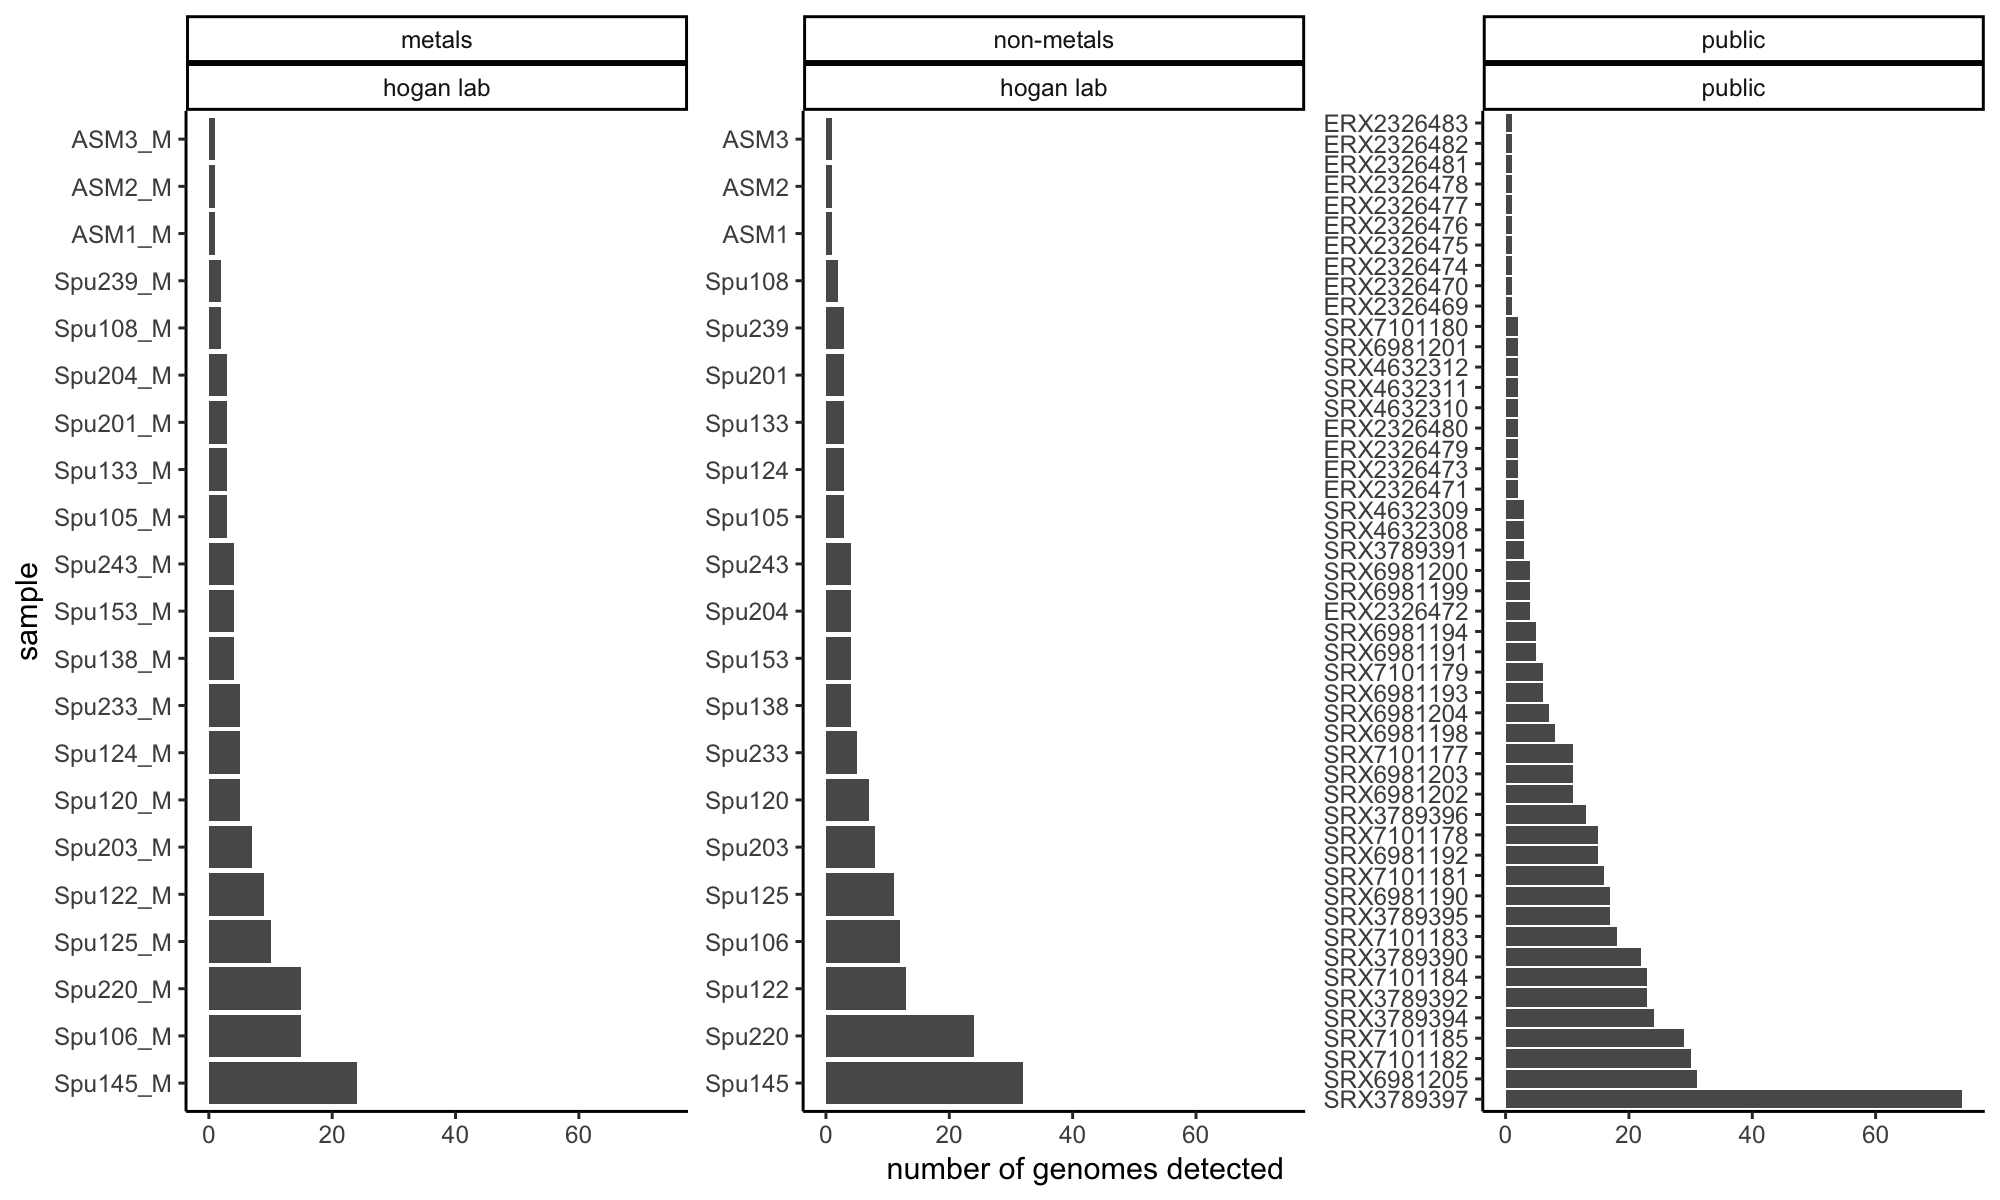

In [72]:
# number of strains per sample
num_gather_results <- gather_results %>%
  group_by(query_name, exp, source) %>%
  tally() %>%
  arrange(desc(n))

ggplot(num_gather_results %>% filter(!query_name %in% c("M633", "M632", "M631")), 
       aes(x = reorder(query_name, -n), y = n)) +
  geom_col() +
  theme_classic() +
  coord_flip() + 
  facet_wrap(~exp + source, scales = "free_y") +
  labs( y = "number of genomes detected", x = "sample")

In [70]:
num_gather_results

query_name,exp,source,n
<chr>,<chr>,<chr>,<int>
SRX3789397,public,public,74
Spu145,non-metals,hogan lab,32
SRX6981205,public,public,31
SRX7101182,public,public,30
SRX7101185,public,public,29
Spu145_M,metals,hogan lab,24
Spu220,non-metals,hogan lab,24
SRX3789394,public,public,24
SRX3789392,public,public,23


## Species plots

In [24]:
gather_results %>%
  group_by(species) %>%
  tally() %>%
  arrange(desc(n))

species,n
<chr>,<int>
s__Pseudomonas aeruginosa,110
NA,68
s__Prevotella melaninogenica,34
s__Streptococcus parasanguinis_B,24
s__Staphylococcus aureus,20
s__Porphyromonas pasteri,18
s__Veillonella parvula_A,17
s__Prevotella histicola,16
s__Rothia mucilaginosa_A,16


In [28]:
unique(sort(gather_results$species))

[1] "s__Achromobacter xylosoxidans"      
  [2] "s__Acinetobacter baumannii"         
  [3] "s__Actinomyces gerencseriae"        
  [4] "s__Actinomyces graevenitzii"        
  [5] "s__Actinomyces israelii"            
  [6] "s__Actinomyces oris"                
  [7] "s__Actinomyces oris_C"              
  [8] "s__Alloprevotella tannerae"         
  [9] "s__Alloscardovia omnicolens"        
 [10] "s__Anaeroglobus micronuciformis"    
 [11] "s__Bacillus intestinalis"           
 [12] "s__Bifidobacterium breve"           
 [13] "s__Bifidobacterium dentium"         
 [14] "s__Bulleidia moorei"                
 [15] "s__Burkholderia cenocepacia_B"      
 [16] "s__Burkholderia mallei"             
 [17] "s__Burkholderia multivorans"        
 [18] "s__Campylobacter_A concisus_R"      
 [19] "s__Campylobacter_A concisus_T"      
 [20] "s__Capnocytophaga endodontalis"     
 [21] "s__Capnocytophaga gingivalis"       
 [22] "s__Capnocytophaga granulosa"        
 [23] "s__Capnocytophaga leadbetteri"      
 [24] "s__Capnocytophaga ochracea"         
 [25] "s__Cutibacterium acnes"             
 [26] "s__Cutibacterium granulosum"        
 [27] "s__Dialister invisus"               
 [28] "s__Eikenella corrodens"             
 [29] "s__Eikenella halliae"               
 [30] "s__Escherichia coli_D"              
 [31] "s__Escherichia flexneri"            
 [32] "s__F0040 sp000318095"               
 [33] "s__F0058 sp000163695"               
 [34] "s__Finegoldia magna"                
 [35] "s__Finegoldia magna_F"              
 [36] "s__Finegoldia magna_H"              
 [37] "s__Friedmanniella luteola"          
 [38] "s__Fusobacterium nucleatum"         
 [39] "s__Fusobacterium periodonticum_D"   
 [40] "s__Fusobacterium vincentii"         
 [41] "s__Gemella haemolysans_B"           
 [42] "s__Gemella sanguinis"               
 [43] "s__Gemella sp900766305"             
 [44] "s__Granulicatella adiacens"         
 [45] "s__Granulicatella sp001058355"      
 [46] "s__Granulicatella sp900551535"      
 [47] "s__Haemophilus haemolyticus"        
 [48] "s__Haemophilus influenzae"          
 [49] "s__Haemophilus sp002998595"         
 [50] "s__Haemophilus_D parainfluenzae"    
 [51] "s__Haemophilus_D parainfluenzae_A"  
 [52] "s__Haemophilus_D parainfluenzae_K"  
 [53] "s__Haemophilus_D parainfluenzae_M"  
 [54] "s__Haemophilus_D sp001815355"       
 [55] "s__Haemophilus_D sp900756155"       
 [56] "s__Haemophilus_D sp900756875"       
 [57] "s__Helcococcus ovis"                
 [58] "s__JABCPE02 sp013333255"            
 [59] "s__Janibacter hoylei"               
 [60] "s__Kingella_A denitrificans"        
 [61] "s__Kingella_B oralis"               
 [62] "s__Lacticaseibacillus rhamnosus"    
 [63] "s__Lactobacillus gasseri"           
 [64] "s__Lactobacillus paragasseri"       
 [65] "s__Lancefieldella sp000564995"      
 [66] "s__Lautropia mirabilis"             
 [67] "s__Lawsonella clevelandensis_A"     
 [68] "s__Leptotrichia massiliensis"       
 [69] "s__Leptotrichia wadei"              
 [70] "s__Leptotrichia_A sp000469505"      
 [71] "s__Leptotrichia_A sp001274535"      
 [72] "s__Limosilactobacillus fermentum"   
 [73] "s__Limosilactobacillus reuteri"     
 [74] "s__Metamycoplasma salivarium"       
 [75] "s__Mogibacterium diversum"          
 [76] "s__Negativicoccus succinicivorans"  
 [77] "s__Neisseria mucosa"                
 [78] "s__Neisseria sp000186165"           
 [79] "s__Neisseria subflava_A"            
 [80] "s__Neisseria subflava_C"            
 [81] "s__Nocardiopsis alba"               
 [82] "s__Olegusella massiliensis"         
 [83] "s__Parvimonas micra"                
 [84] "s__Pauljensenia odontolytica_B"     
 [85] "s__Pauljensenia sp000278725"        
 [86] "s__Pauljensenia sp000308055"        
 [87] "s__Pauljensenia sp000411415"        
 [88] "s__Pauljensenia sp000466265"        
 [89] "s__Pauljensenia sp000758755"        
 [90] "s__Pauljensenia sp001838165"        
 [91] "s__Peptoniphilus_A harei_A"        

In [30]:
gather_results_species <- gather_results %>%
  mutate(species_label = ifelse(species %in% species_of_interest, species, "other"))

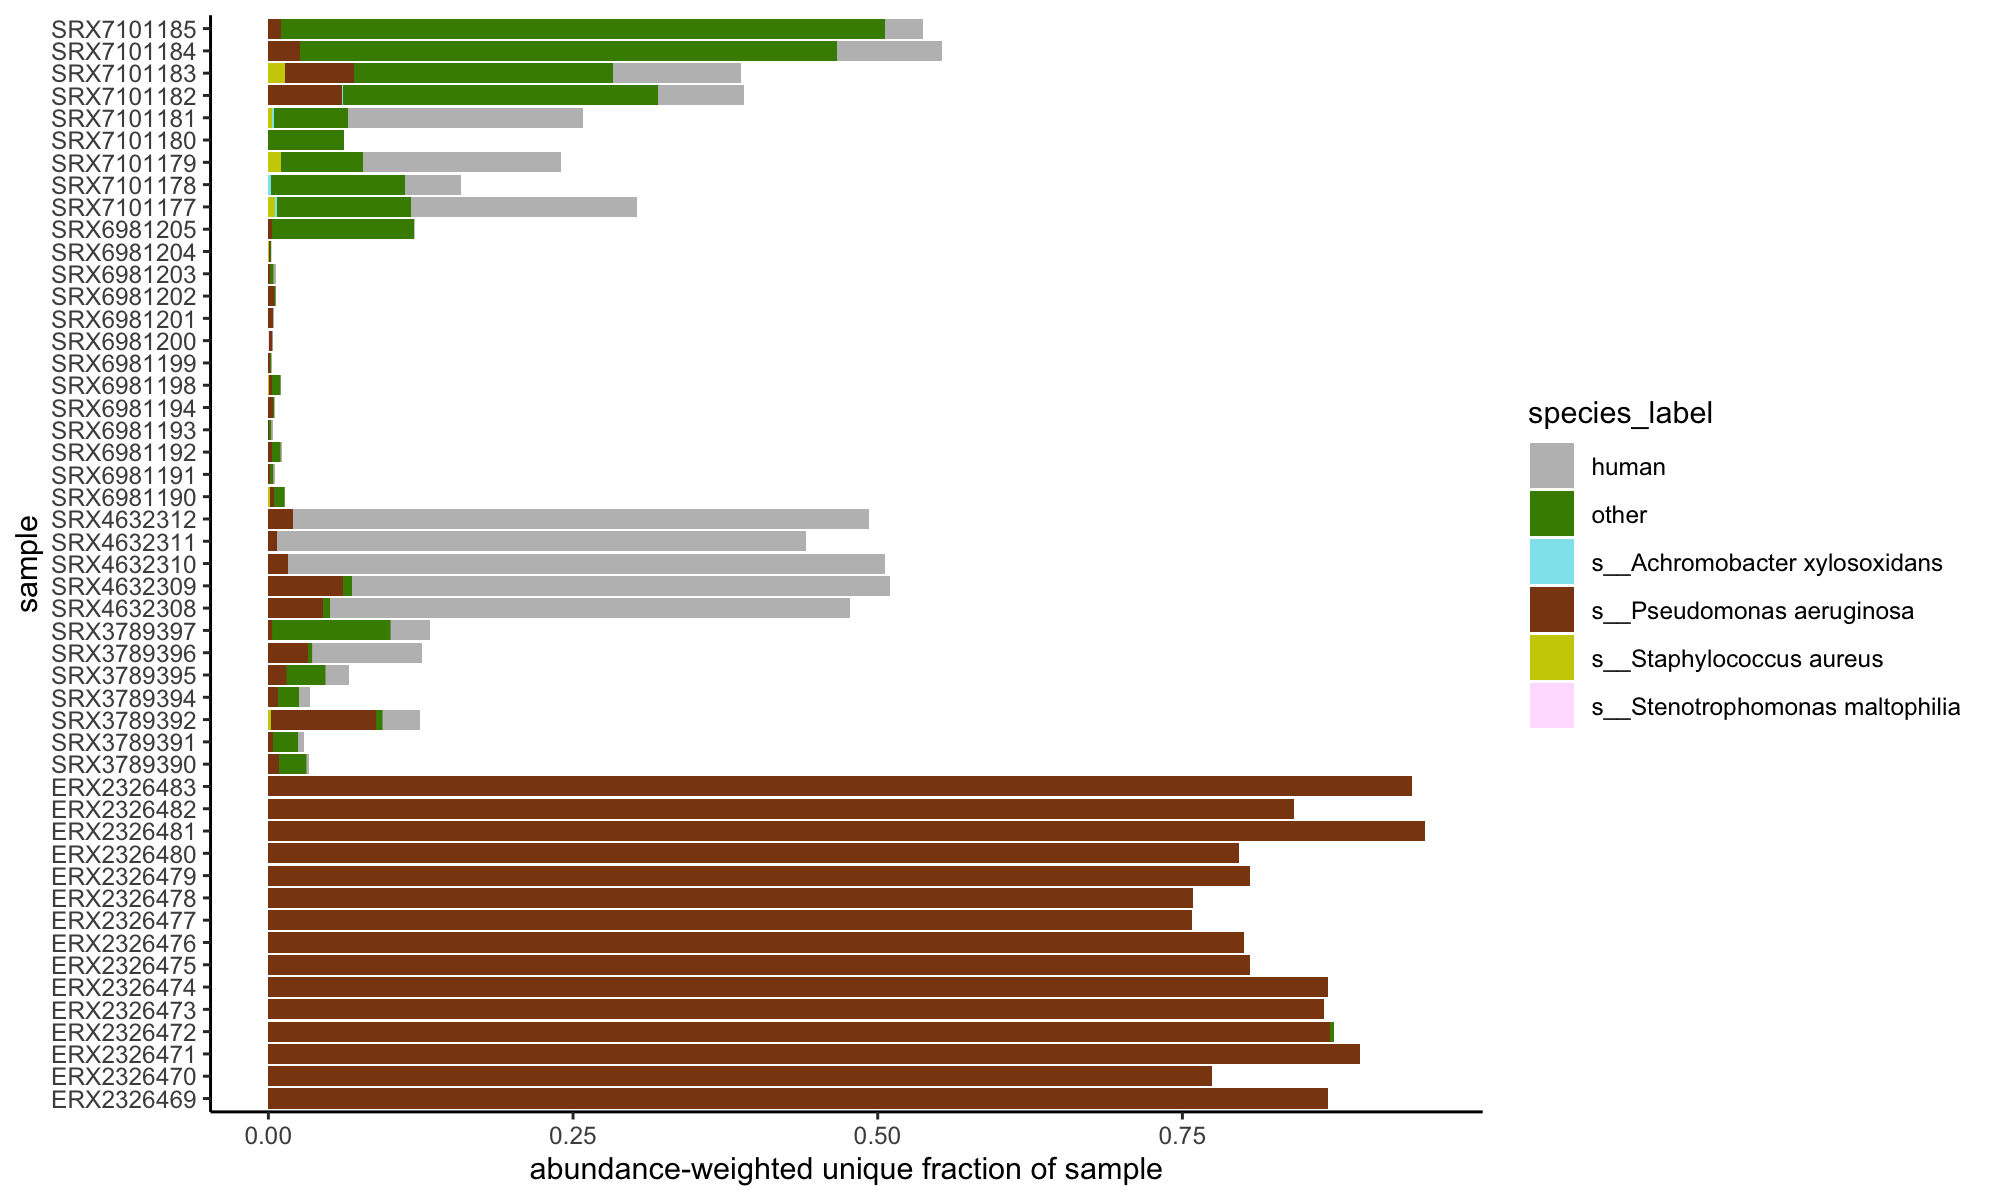

In [56]:
ggplot(gather_results_species %>% filter(source == "public"), 
       aes(x = query_name, y = f_unique_weighted, fill = species_label)) + 
  geom_col() +
  scale_fill_manual(values = c("grey", "chartreuse4", "cadetblue2",  "chocolate4", "yellow3", "thistle1")) +
  theme_classic() +
  coord_flip() +
  labs(x = "sample", y = "abundance-weighted unique fraction of sample")

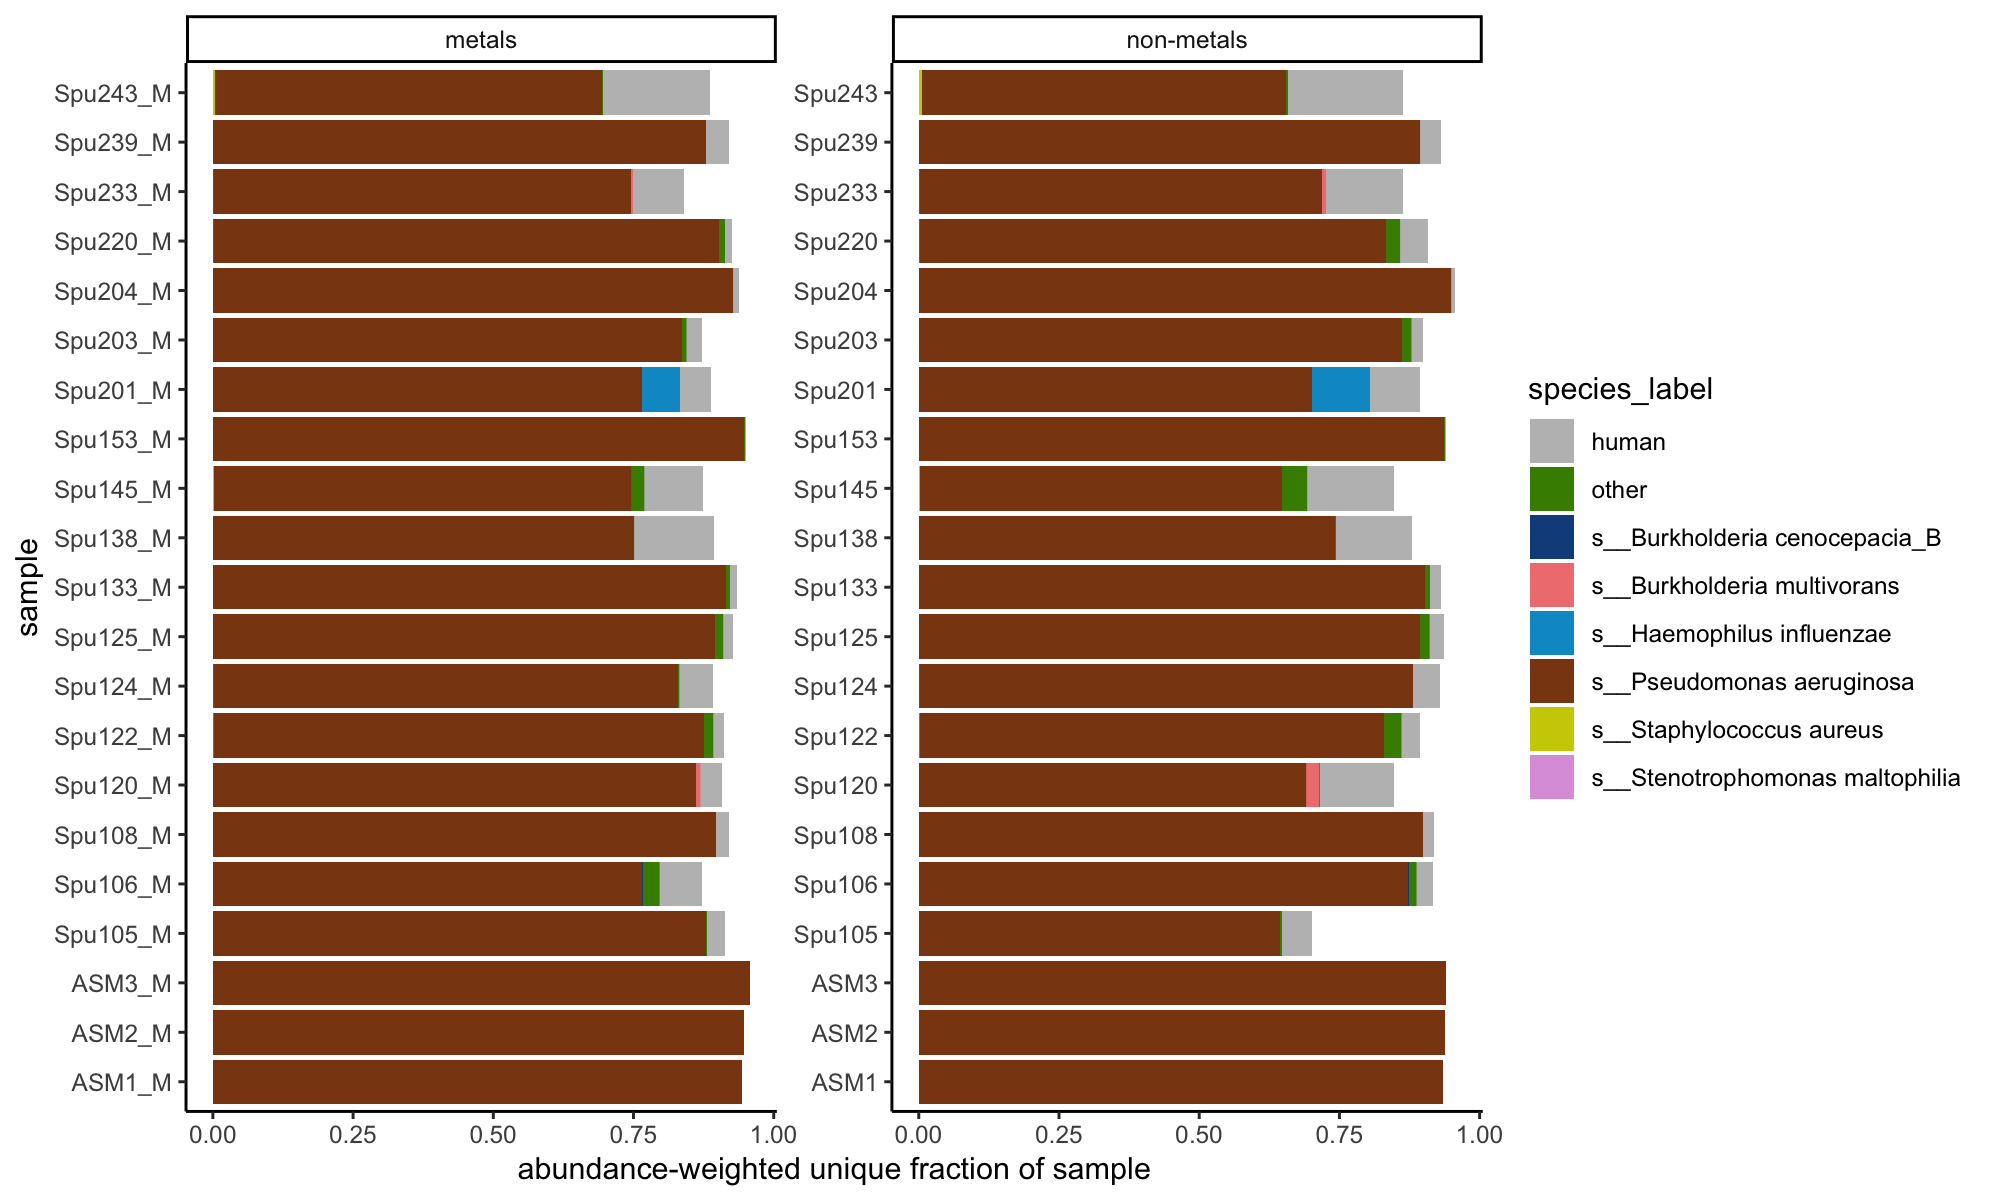

In [55]:
ggplot(gather_results_species %>% filter(source == "hogan lab") %>% filter(!query_name %in% c("M633", "M632", "M631")),
       aes(x = query_name, y = f_unique_weighted, fill = species_label)) + 
  geom_col() +
  scale_fill_manual(values = c("grey", "chartreuse4", "dodgerblue4", "lightcoral", "deepskyblue3", "chocolate4", "yellow3", "plum")) +
  theme_classic() +
  coord_flip() +
  facet_wrap(~exp, scales = "free_y") +
  labs(x = "sample", y = "abundance-weighted unique fraction of sample")